Files already downloaded and verified
Files already downloaded and verified
train_dataset =  50000
test_dataset =  10000
torch.Size([3, 32, 32])


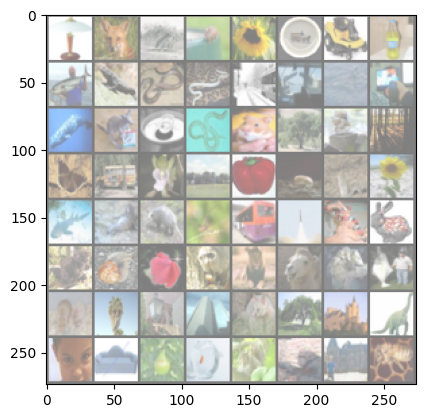

Epoch [1/20], Loss: 0.0720, val_loss: 0.0723, val_acc: 0.0130
Epoch [2/20], Loss: 0.0705, val_loss: 0.0683, val_acc: 0.0359
Epoch [3/20], Loss: 0.0650, val_loss: 0.0630, val_acc: 0.0827
Epoch [4/20], Loss: 0.0608, val_loss: 0.0585, val_acc: 0.1253
Epoch [5/20], Loss: 0.0559, val_loss: 0.0529, val_acc: 0.1923
Epoch [6/20], Loss: 0.0521, val_loss: 0.0500, val_acc: 0.2228
Epoch [7/20], Loss: 0.0486, val_loss: 0.0476, val_acc: 0.2463
Epoch [8/20], Loss: 0.0455, val_loss: 0.0436, val_acc: 0.3038
Epoch [9/20], Loss: 0.0428, val_loss: 0.0418, val_acc: 0.3236
Epoch [10/20], Loss: 0.0401, val_loss: 0.0394, val_acc: 0.3633
Epoch [11/20], Loss: 0.0373, val_loss: 0.0375, val_acc: 0.3850
Epoch [12/20], Loss: 0.0351, val_loss: 0.0360, val_acc: 0.4072
Epoch [13/20], Loss: 0.0327, val_loss: 0.0346, val_acc: 0.4267
Epoch [14/20], Loss: 0.0305, val_loss: 0.0340, val_acc: 0.4333
Epoch [15/20], Loss: 0.0284, val_loss: 0.0338, val_acc: 0.4388
Epoch [16/20], Loss: 0.0264, val_loss: 0.0323, val_acc: 0.4623
E

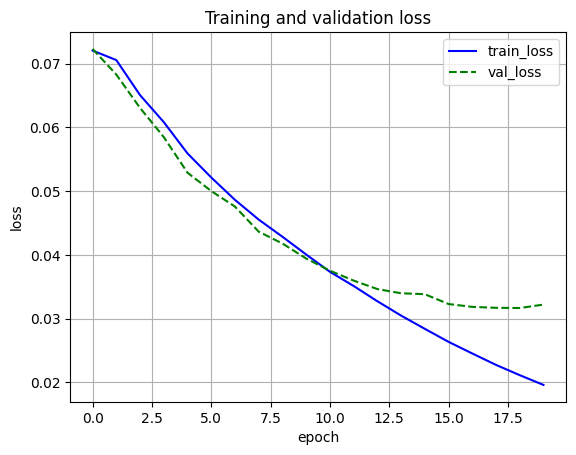

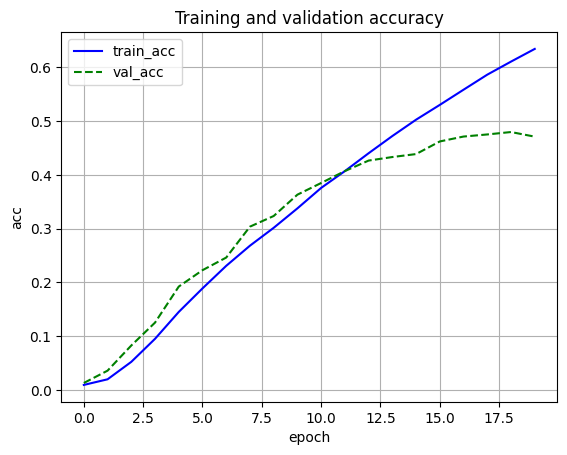

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

# load CIFAR-100 data
train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

print('train_dataset = ', len(train_dataset))
print('test_dataset = ', len(test_dataset))
image, label = train_dataset[0]
print(image.size())

# set data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))

# Alexnet
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

# select device
num_classes = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# training
num_epochs = 20
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

### training
for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    # ====== train_mode ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ====== val_mode ======
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)

    print('Epoch [{}/{}], Loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'
          .format(epoch + 1, num_epochs, avg_train_loss, avg_val_loss, avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

# plot graph
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

plt.show()
